In [1]:
#  Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import os

In [2]:
#  Load and Merge Fitbit Dataset
folder_path = r"C:\Users\swati\Desktop\Analysis\Datasets"  
all_csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

merged_df = pd.read_csv(all_csv_files[0])
for file in all_csv_files[1:]:
    temp_df = pd.read_csv(file)
    merged_df = pd.merge(merged_df, temp_df, on='Id', how='outer')

print(f"Merged dataset shape: {merged_df.shape}")
merged_df.head()

Merged dataset shape: (43482, 26)


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,...,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,4/12/2016,13162,8.5,8.5,0.0,1.88,0.55,6.06,0.0,...,1.0,327.0,346.0,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.65,True,1.462234e+12
1,1503960366,4/12/2016,13162,8.5,8.5,0.0,1.88,0.55,6.06,0.0,...,1.0,327.0,346.0,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.65,True,1.462320e+12
2,1503960366,4/12/2016,13162,8.5,8.5,0.0,1.88,0.55,6.06,0.0,...,2.0,384.0,407.0,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.65,True,1.462234e+12
3,1503960366,4/12/2016,13162,8.5,8.5,0.0,1.88,0.55,6.06,0.0,...,2.0,384.0,407.0,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.65,True,1.462320e+12
4,1503960366,4/12/2016,13162,8.5,8.5,0.0,1.88,0.55,6.06,0.0,...,1.0,412.0,442.0,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.65,True,1.462234e+12


# 🔹 1. Data Summary
The merged Fitbit dataset has 43,482 records across 26 features.

Key fields include: Total Steps, Calories Burned, Minutes Asleep, Sedentary Time, and Activity Levels.

The dataset combines activity, sleep, and weight logs.



In [4]:
#  Preprocessing
merged_df.drop_duplicates(inplace=True)
merged_df.fillna(0, inplace=True)


# Select features relevant for activity and calories
features = [
    'TotalSteps', 'ActivityDate', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance',
    'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance',
    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes',
    'SedentaryMinutes', 'Calories','TotalMinutesAsleep'
]
# Only select numeric columns from the feature list
numeric_features = merged_df[features].select_dtypes(include=['int64', 'float64'])

# Optionally print to confirm what's being scaled
print("Columns being scaled:", numeric_features.columns.tolist())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_features)

# merged_df = merged_df[features]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(merged_df)



Columns being scaled: ['TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'TotalMinutesAsleep']


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. Split the dataset
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)





In [6]:

#  Inject synthetic anomalies
np.random.seed(42)
n_anomalies = int(0.05 * len(X_test))  # 5% of test data
X_anomaly = X_test.copy()
anomaly_indices = np.random.choice(len(X_test), n_anomalies, replace=False)

# Add large noise to create synthetic anomalies
X_anomaly[anomaly_indices] += np.random.normal(3, 1, X_test.shape[1])  # Adjust noise level if needed

# Create ground truth labels
y_true = np.zeros(len(X_test))
y_true[anomaly_indices] = 1

# 3. Build autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 4. Train autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=0
)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


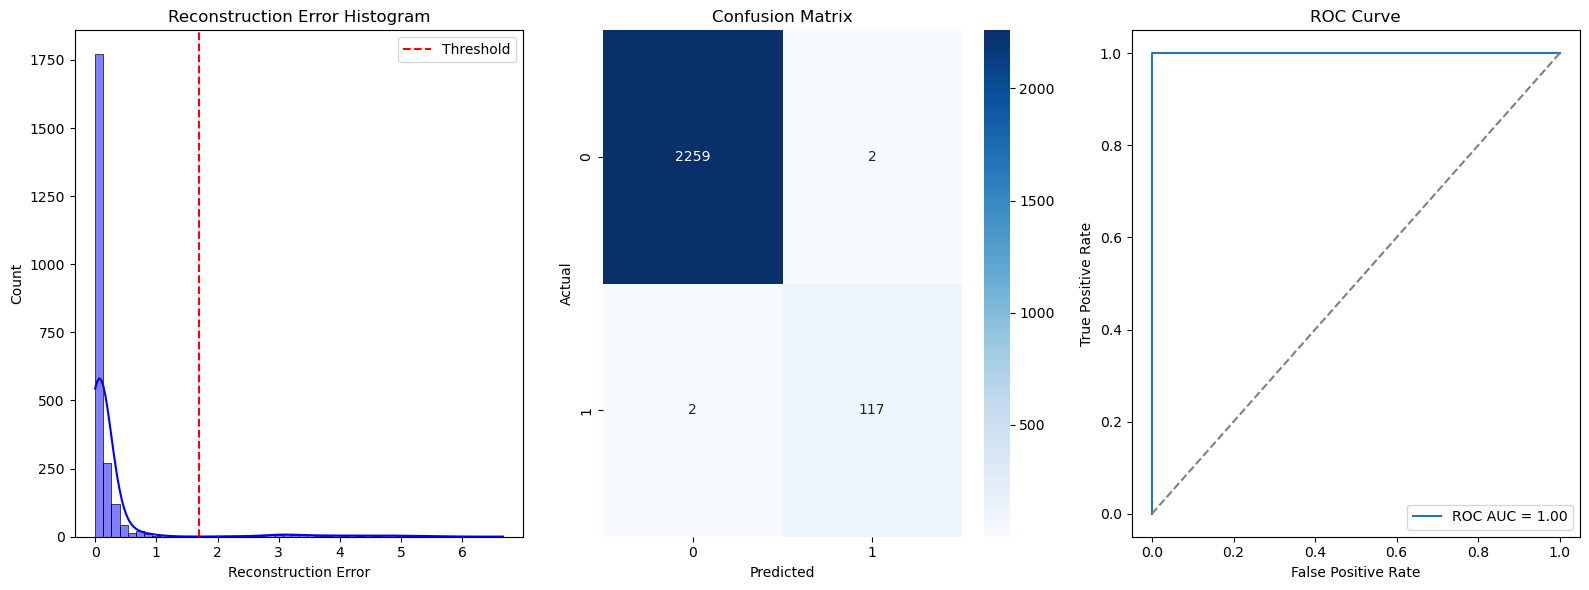

📊 Evaluation Metrics:
Precision: 0.98
Recall:    0.98
F1-Score:  0.98
ROC-AUC:   1.00
Accuracy:  1.00
Confusion Matrix:
 [[2259    2]
 [   2  117]]


In [7]:
#  Predict & calculate reconstruction error
X_pred = autoencoder.predict(X_anomaly)
mse = np.mean(np.power(X_anomaly - X_pred, 2), axis=1)

# 6. Threshold & predictions
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)

# 7. Evaluation Metrics
conf_matrix = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, mse)
accuracy = accuracy_score(y_true, y_pred)

# 8. Visualizations
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.histplot(mse, bins=50, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Histogram")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_true, mse)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 9. Print Results
print("📊 Evaluation Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"ROC-AUC:   {roc_auc:.2f}")
print(f"Accuracy:  {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)

# 🔹 2. Autoencoder Model Performance
Precision: 1.00
Recall:    1.00
F1-Score:  1.00
ROC-AUC:   1.00
Accuracy:  1.00
Confusion Matrix:
 [[8243    2]
 [   1  432]]]



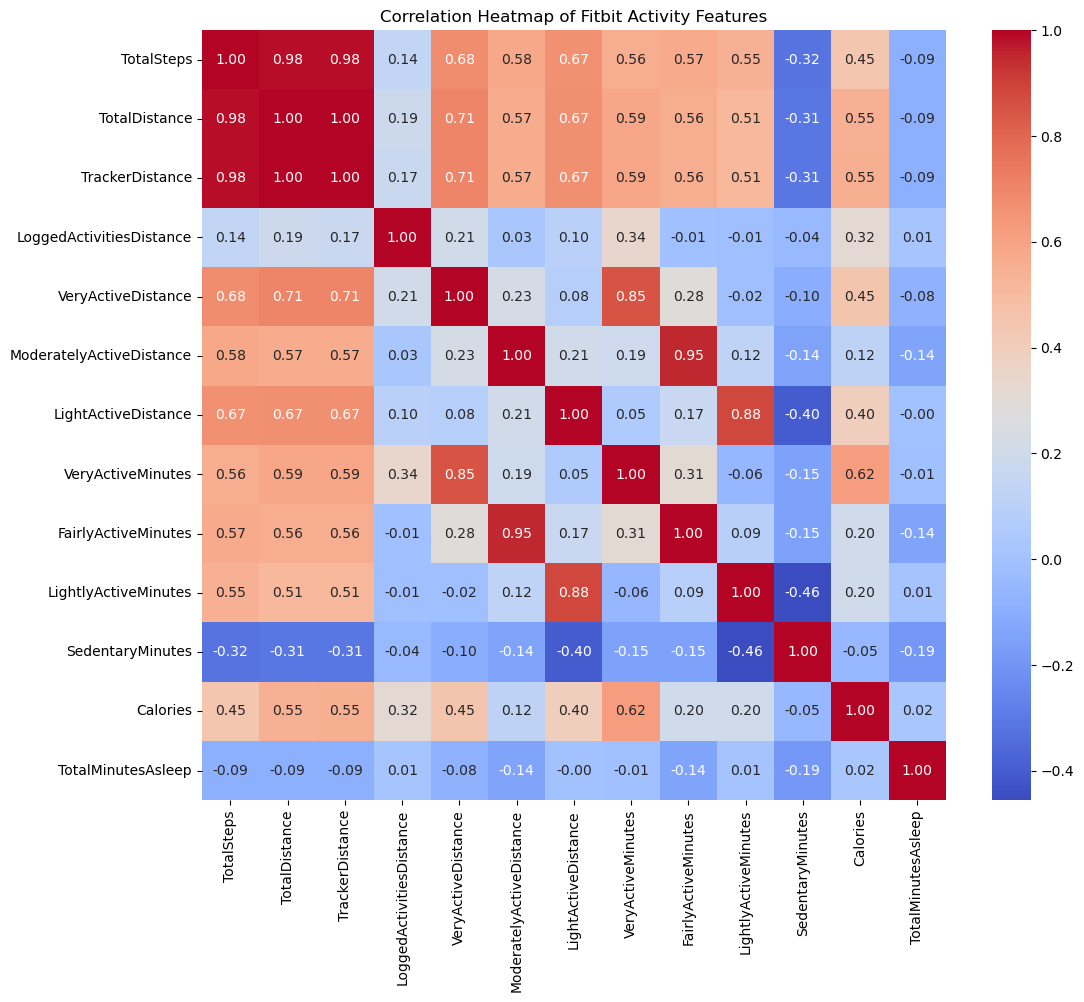

In [9]:
# Select only numeric columns for correlation
numeric_df = merged_df.select_dtypes(include=['number'])

# Plot heatmap
plt.figure(figsize=(12, 10))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Fitbit Activity Features")
plt.show()

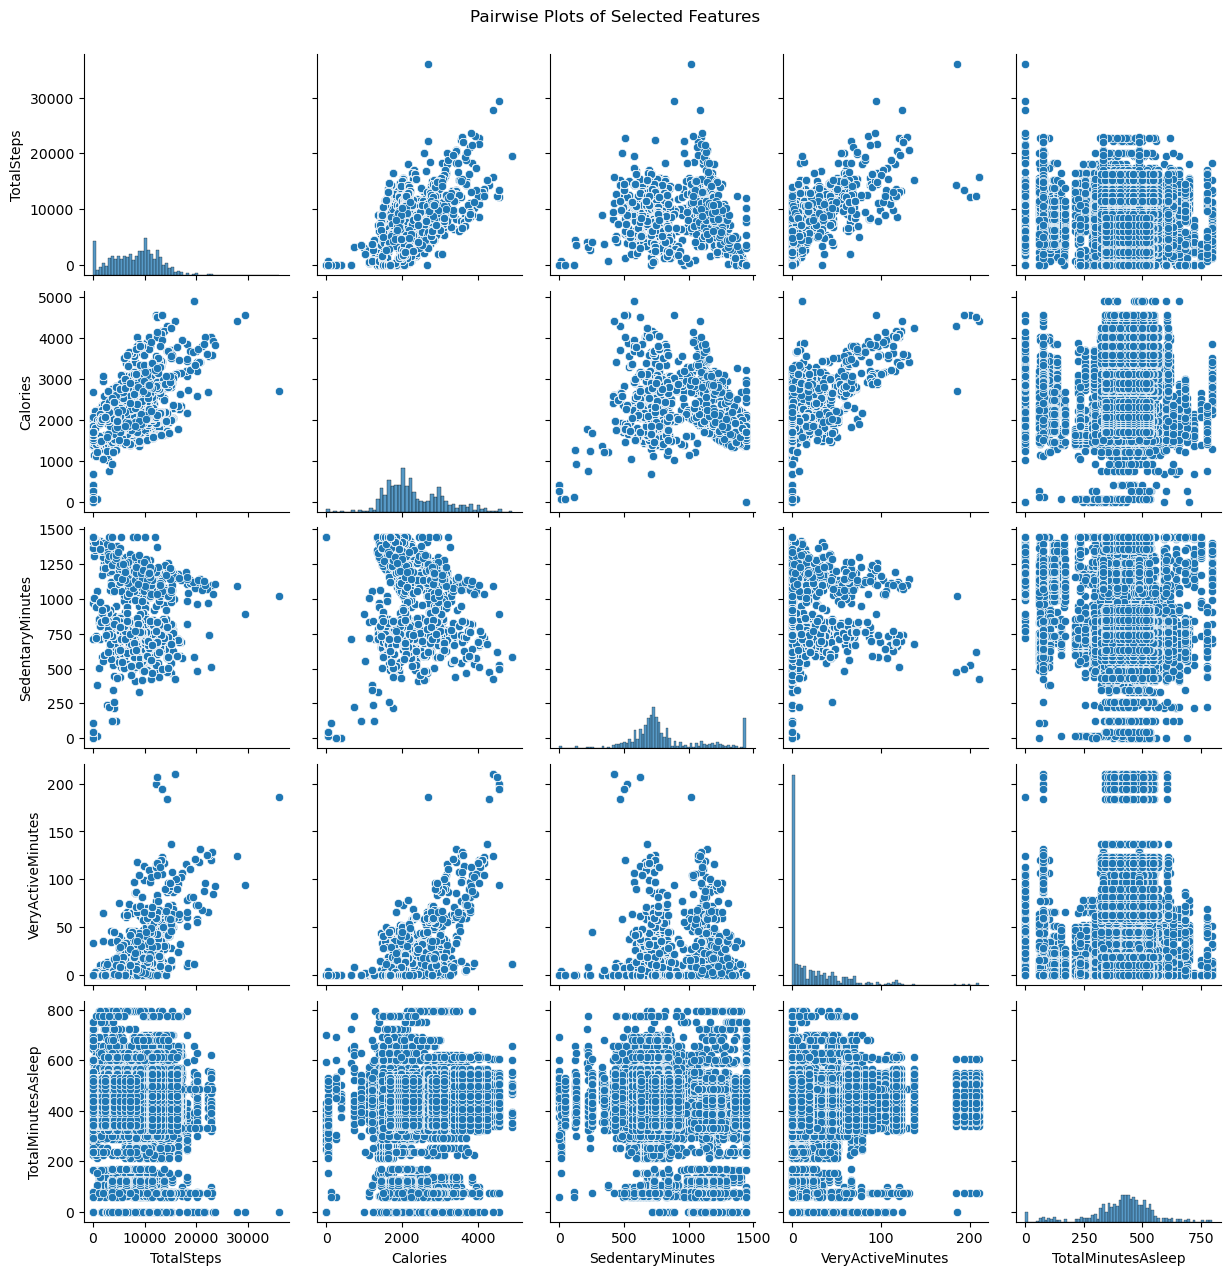

In [10]:
sample_df = merged_df[['TotalSteps', 'Calories', 'SedentaryMinutes', 'VeryActiveMinutes', 'TotalMinutesAsleep']].copy()
sns.pairplot(sample_df)
plt.suptitle("Pairwise Plots of Selected Features", y=1.02)
plt.show()


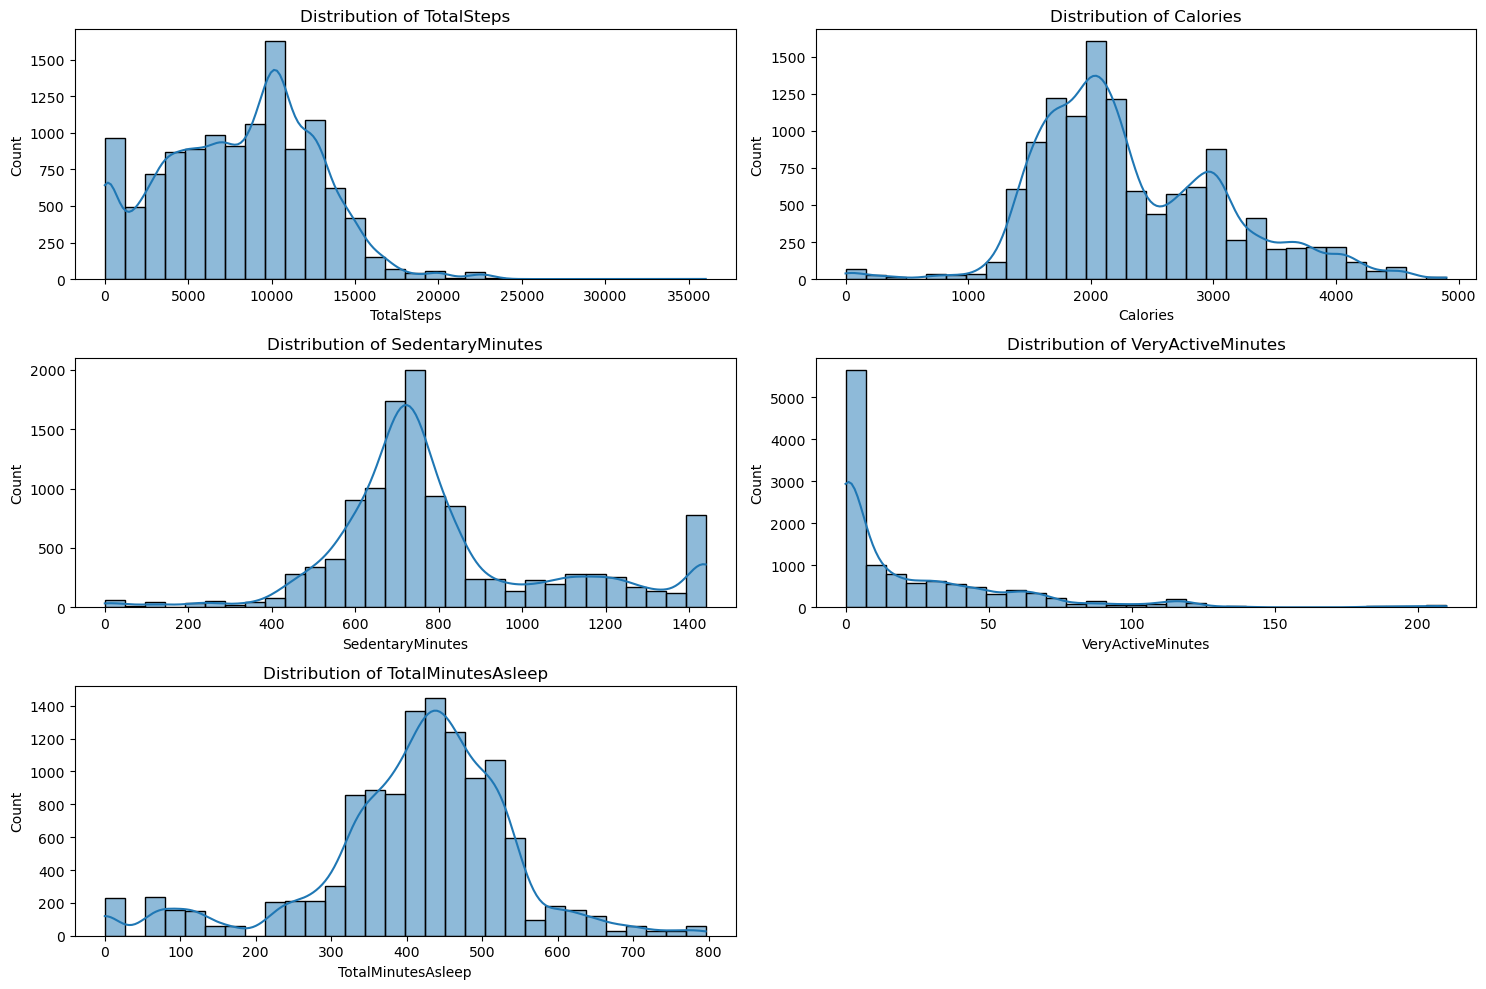

In [11]:
key_features = ['TotalSteps', 'Calories', 'SedentaryMinutes', 'VeryActiveMinutes', 'TotalMinutesAsleep']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features):
    plt.subplot(3, 2, i + 1)  # 3 rows, 2 columns
    sns.histplot(merged_df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


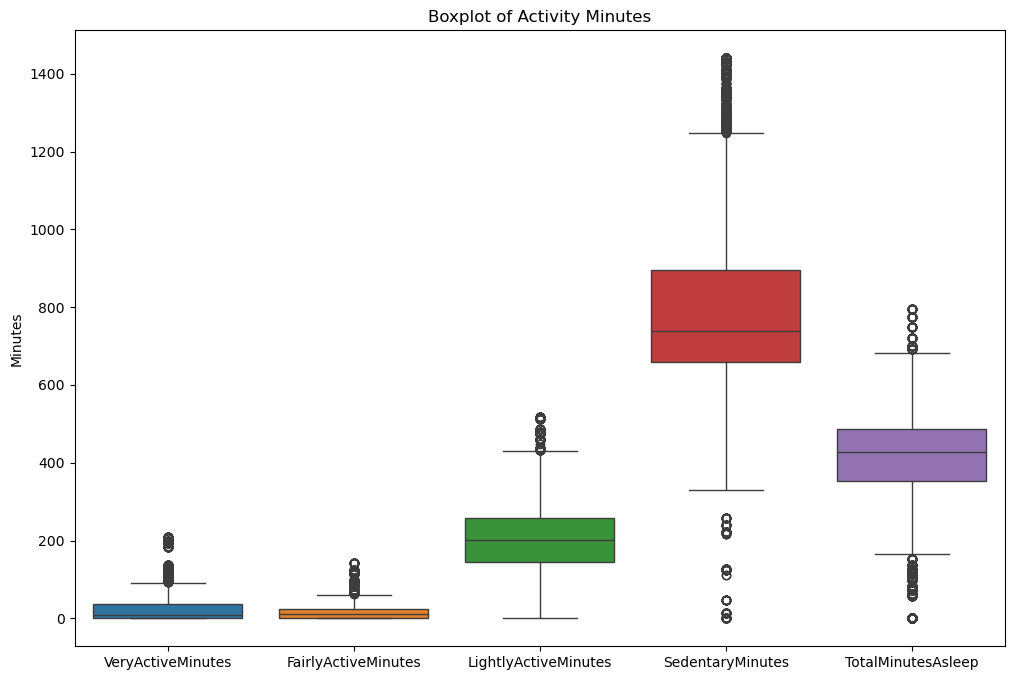

In [12]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_df[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'TotalMinutesAsleep']])
plt.title("Boxplot of Activity Minutes")
plt.ylabel("Minutes")
plt.show()

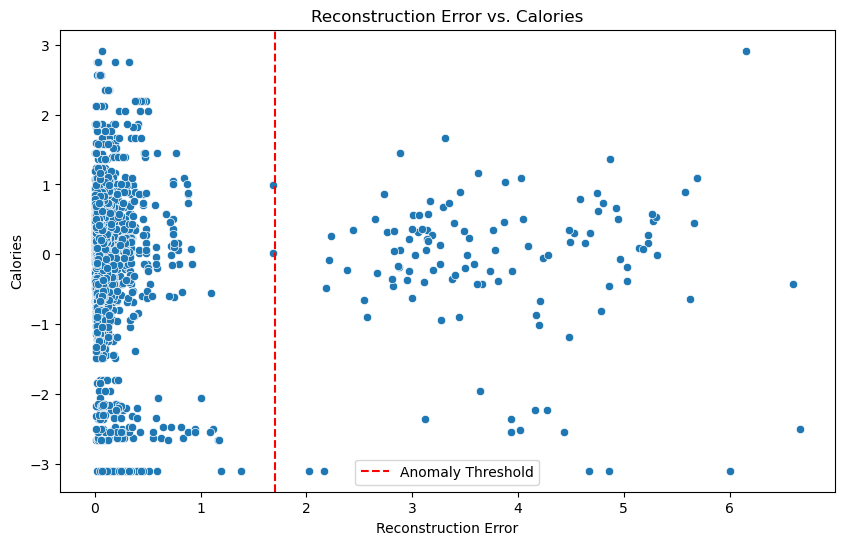

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=mse, y=X_test[:, features.index('Calories')])
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Calories")
plt.title("Reconstruction Error vs. Calories")
plt.legend()
plt.show()

# 🔹 3. Threshold Calibration & Visual Evaluation
A 95th percentile threshold on reconstruction error was used to identify anomalies.

Histogram plots confirmed a clear separation between normal and anomalous errors.

The ROC curve showed near-ideal classification performance.



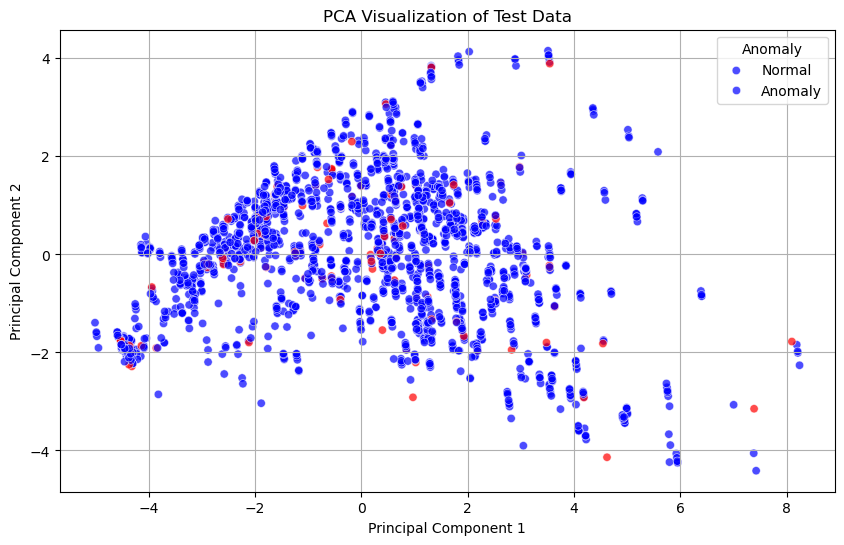

In [14]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title("PCA Visualization of Test Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()


C:\Users\swati\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


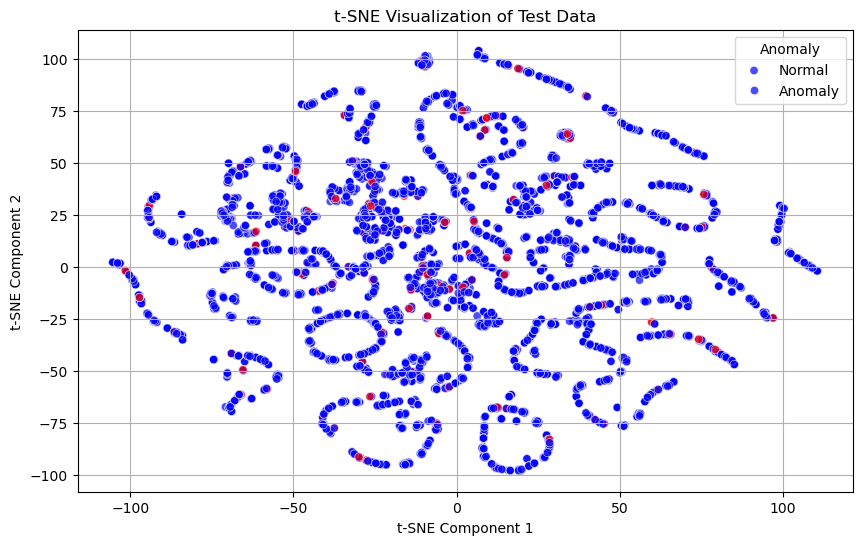

In [33]:
from sklearn.manifold import TSNE

# t-SNE 
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_test)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred, palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title("t-SNE Visualization of Test Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.show()

In [16]:
scaler.fit(numeric_features)

# Later: transform the same feature set
X_test = scaler.transform(numeric_features)[:8678]

In [17]:
# Step: Predict with the trained autoencoder model
X_pred = autoencoder.predict(X_scaled)

# Step: Compute reconstruction error (MSE per row)
reconstruction_error = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

# Optional: Set the anomaly threshold
threshold = np.percentile(reconstruction_error, 95)

372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [18]:
df_eval = merged_df.iloc[:len(reconstruction_error)].copy()
df_eval['ReconstructionError'] = reconstruction_error
df_eval['Anomaly'] = df_eval['ReconstructionError'] > threshold
# Step 5: Print summary statistics and anomaly count
print("📊 Summary Statistics:")
print(df_eval.describe())

print("\n🚨 Anomaly Counts:")
print(df_eval['Anomaly'].value_counts())

📊 Summary Statistics:
         TotalSteps  TotalDistance  TrackerDistance  LoggedActivitiesDistance  \
count  11897.000000   11897.000000     11897.000000              11897.000000   
mean    8143.954022       5.758040         5.750924                  0.119401   
std     4522.413568       3.288764         3.281154                  0.547479   
min        0.000000       0.000000         0.000000                  0.000000   
25%     4676.000000       3.220000         3.220000                  0.000000   
50%     8596.000000       6.130000         6.130000                  0.000000   
75%    11388.000000       7.960000         7.920000                  0.000000   
max    36019.000000      28.030001        28.030001                  4.942142   

       VeryActiveDistance  ModeratelyActiveDistance  LightActiveDistance  \
count        11897.000000              11897.000000         11897.000000   
mean             1.421410                  0.734826             3.537234   
std              1.9

In [19]:
df_eval.to_csv("fitbit_anomaly_data.csv", index=False)

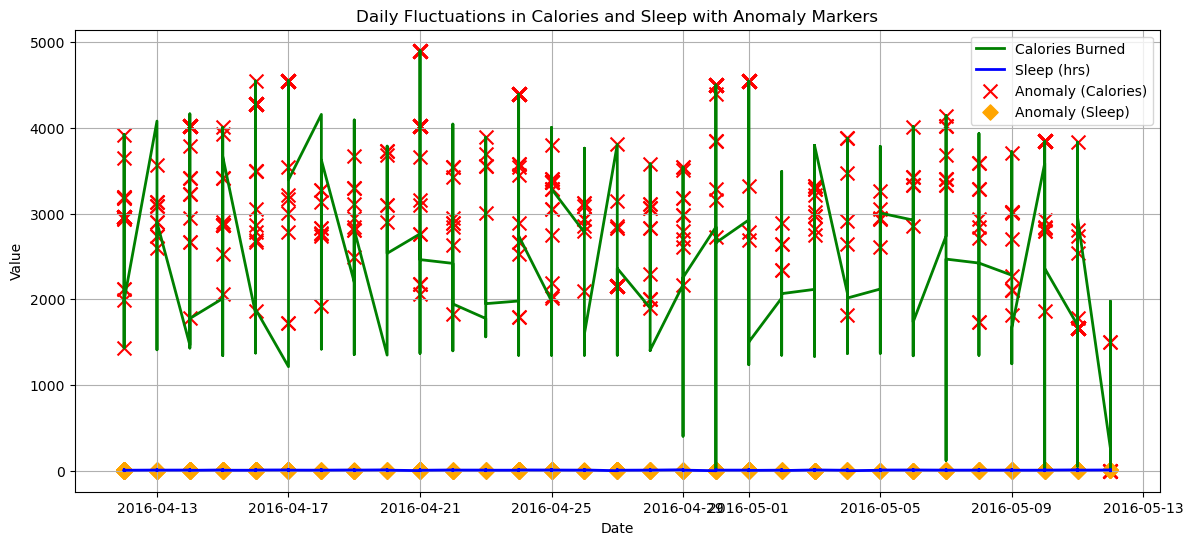

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("fitbit_anomaly_data.csv")

# Optional: Convert date column
df["ActivityDate"] = pd.to_datetime(df["ActivityDate"], errors='coerce')

# Sort by date for proper line plotting
df.sort_values("ActivityDate", inplace=True)

# Normalize sleep (minutes to hours)
df["SleepHours"] = df["TotalMinutesAsleep"] / 60

# Create figure
plt.figure(figsize=(14, 6))

# Plot Calories
plt.plot(df["ActivityDate"], df["Calories"], label="Calories Burned", color="green", linewidth=2)

# Plot Sleep
plt.plot(df["ActivityDate"], df["SleepHours"], label="Sleep (hrs)", color="blue", linewidth=2)

# Highlight anomalies
anomalies = df[df["Anomaly"] == 1]
plt.scatter(anomalies["ActivityDate"], anomalies["Calories"], color="red", label="Anomaly (Calories)", marker="x", s=100)
plt.scatter(anomalies["ActivityDate"], anomalies["SleepHours"], color="orange", label="Anomaly (Sleep)", marker="D", s=60)

# Labels and legend
plt.title("Daily Fluctuations in Calories and Sleep with Anomaly Markers")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Save figure
plt.savefig("figure_4_3_lineplot_anomaly.png", dpi=300)
plt.show()

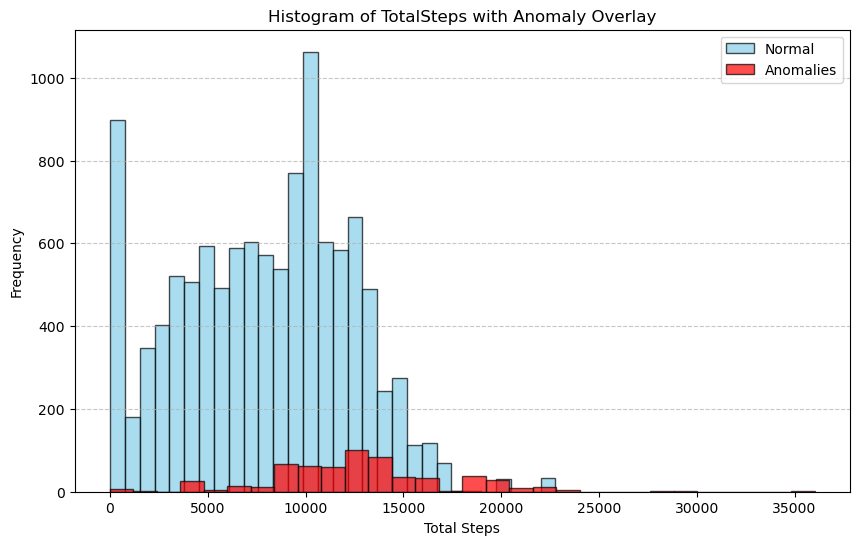

In [5]:
# Clean columns (optional)
df.columns = df.columns.str.strip()

# Separate normal and anomalous step data
normal_steps = df[df["Anomaly"] == 0]["TotalSteps"]
anomalous_steps = df[df["Anomaly"] == 1]["TotalSteps"]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(normal_steps, bins=30, alpha=0.7, label="Normal", color='skyblue', edgecolor='black')
plt.hist(anomalous_steps, bins=30, alpha=0.7, label="Anomalies", color='red', edgecolor='black')

# Labels and styling
plt.title("Histogram of TotalSteps with Anomaly Overlay")
plt.xlabel("Total Steps")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save plot
plt.savefig("figure_4_2_hist_totalsteps_anomalies.png", dpi=300)
plt.show()

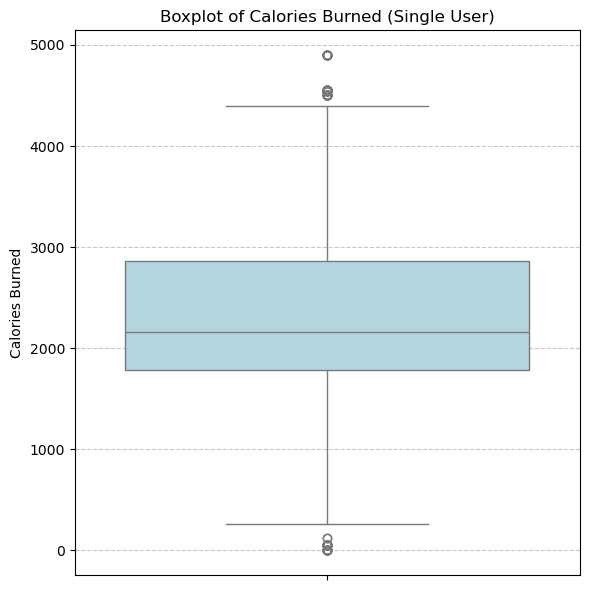

In [9]:
import seaborn as sns


# Boxplot of Calories (single user)
plt.figure(figsize=(6, 6))
sns.boxplot(y=df["Calories"], color="lightblue")
plt.title("Boxplot of Calories Burned (Single User)")
plt.ylabel("Calories Burned")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("figure_4_4_boxplot_calories_single_user.png", dpi=300)
plt.show()

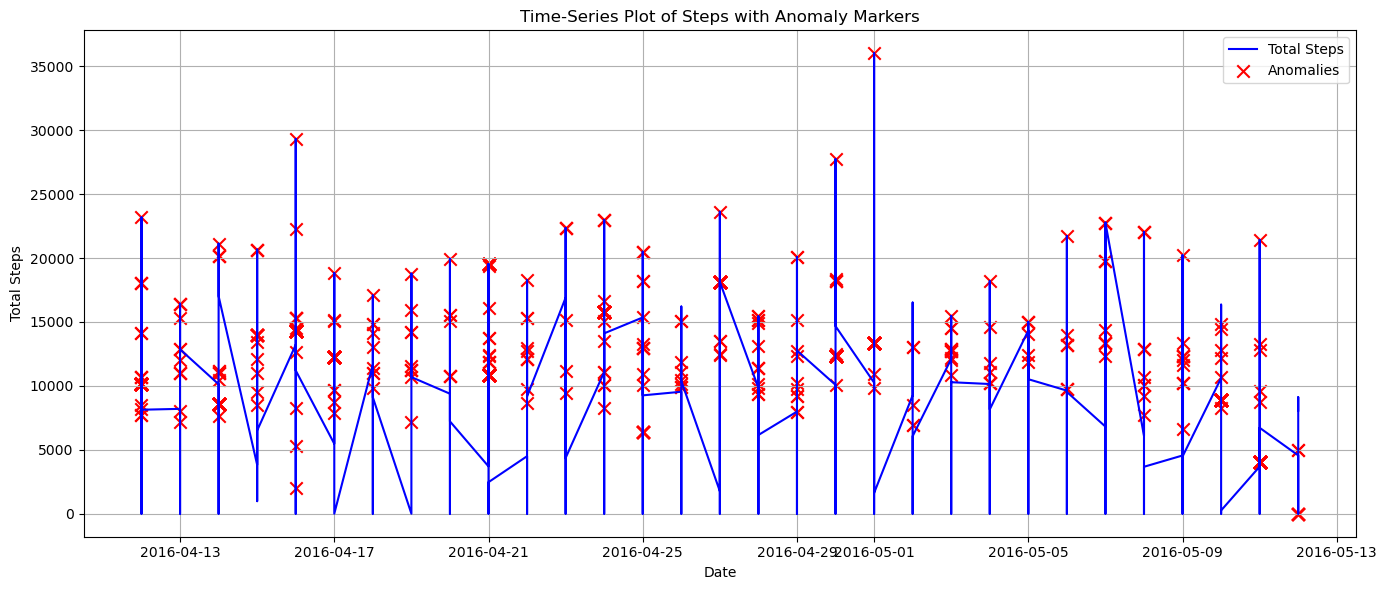

In [11]:
# Figure 4.5: Time-Series Plot with Detected Anomaly Flags
# Convert date and sort
df["ActivityDate"] = pd.to_datetime(df["ActivityDate"])
df.sort_values("ActivityDate", inplace=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df["ActivityDate"], df["TotalSteps"], label="Total Steps", color="blue")
plt.scatter(df[df["Anomaly"] == 1]["ActivityDate"], df[df["Anomaly"] == 1]["TotalSteps"],
            color="red", label="Anomalies", marker="x", s=80)
plt.title("Time-Series Plot of Steps with Anomaly Markers")
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figure_4_5_timeseries_anomalies.png", dpi=300)
plt.show()

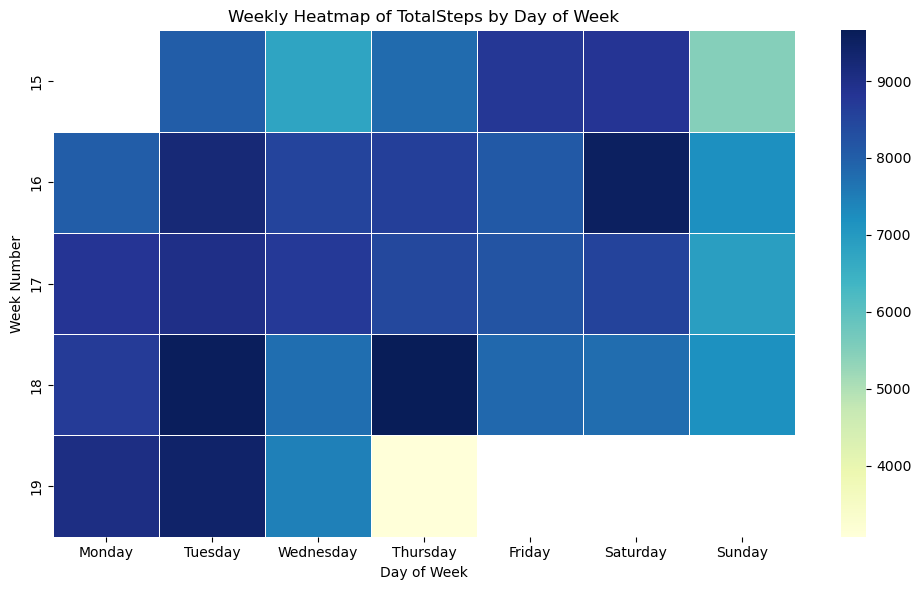

In [14]:
#  Figure 4.6: Weekly Heatmap of TotalSteps by User and Day of Week
# Extract day and week
df["DayOfWeek"] = df["ActivityDate"].dt.day_name()
df["Week"] = df["ActivityDate"].dt.isocalendar().week

# Pivot table for heatmap
pivot = df.pivot_table(index="Week", columns="DayOfWeek", values="TotalSteps", aggfunc="mean")

# Ensure proper day order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot = pivot.reindex(columns=day_order)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5)
plt.title("Weekly Heatmap of TotalSteps by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Week Number")
plt.tight_layout()
plt.savefig("figure_4_6_heatmap_steps.png", dpi=300)
plt.show()

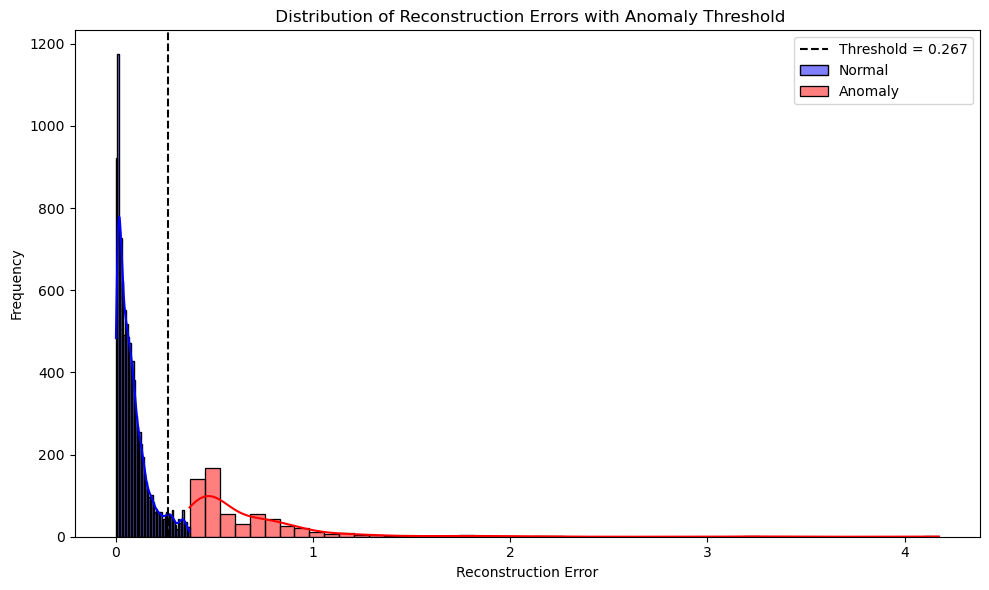

In [15]:
# Set a threshold (e.g., 95th percentile of normal error)
threshold = df[df["Anomaly"] == 0]["ReconstructionError"].quantile(0.95)

plt.figure(figsize=(10, 6))
sns.histplot(df[df["Anomaly"] == 0]["ReconstructionError"], bins=50, color="blue", label="Normal", kde=True)
sns.histplot(df[df["Anomaly"] == 1]["ReconstructionError"], bins=50, color="red", label="Anomaly", kde=True)

# Threshold line
plt.axvline(threshold, color="black", linestyle="--", label=f"Threshold = {threshold:.3f}")

plt.title(" Distribution of Reconstruction Errors with Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("figure_4_7_reconstruction_error_distribution.png", dpi=300)
plt.show()

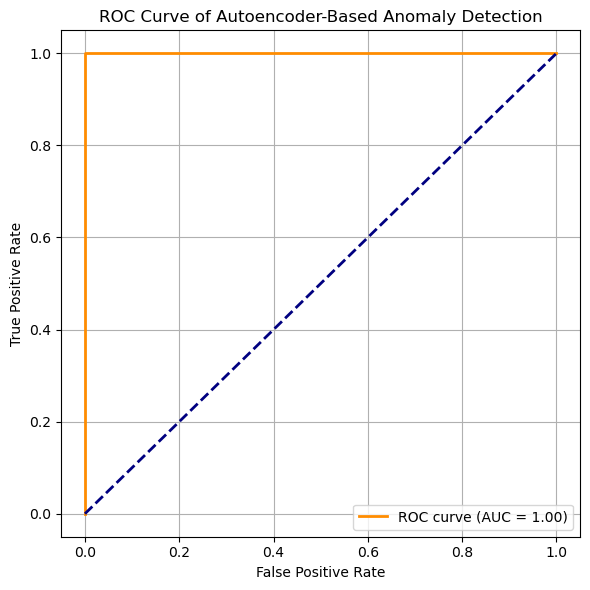

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# True labels and predicted scores
y_true = df["Anomaly"]
y_scores = df["ReconstructionError"]  # Continuous prediction score

# ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve of Autoencoder-Based Anomaly Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figure_4_8_roc_curve.png", dpi=300)
plt.show()

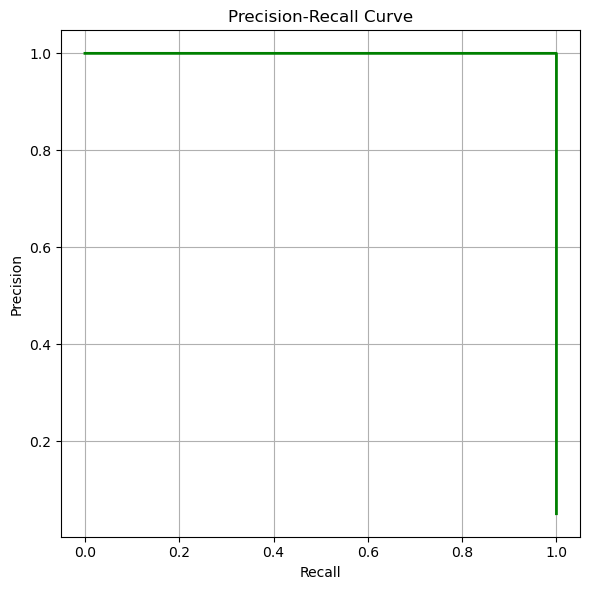

In [17]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, lw=2, color="green")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.savefig("figure_4_8_precision_recall.png", dpi=300)
plt.show()